# Specimage module 
## example using the Myelin Raman data

- This is an example of usage of the specimage module, and include the analysis done with the myelin Raman data set.

First, we have to import a few modules. Notice that we also add the path to where we can find the **specimage** module before importing it.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
# change next line to the directory where you have the specimage.py file
rootpath = "/home/leo/Academic/Projects/github/specimage/"
sys.path.append(rootpath)
from specimage import *
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rpy2.robjects, rpy2.robjects.numpy2ri # read Rdata objects from R 
from scipy.stats import gaussian_kde # http://milkbox.net/note/gaussian-kde-smoothed-histograms-with-matplotlib/

We oppened the original matlab file using the R statistical language and exported each data matrix (each Raman image and mask file) as one separate Rdata file (the standard format for storing R structures).

The R script used was:

```R
library("R.matlab");
mt <- readMat("Analysis_masks.mat");
for (i in 1:84) { # the matlab file has 84 distinct objects (matrices), some will not be used 
  x<-mt[[i]]; # ALL files will have same variable name, "x", but different data
  save(x, file=paste(names(mt)[i],".Rdata",sep=""),compress=TRUE);
  # Rdata format specific to R but fast to save/load
}
```
The file *02.file_shape.txt* was also created by hand with the mask files corresponding to each Raman image file. Specimage can save these files as HDF5 (compatible with Matlab) but it is also fast to import the Rdata files using the **rpy2** library.  

### Reading the Rdata files and creating a collated image with all Raman spectra
(Notice that due to size restrictions the *big* directory with large files is not included in the github repository)

In [2]:
path = rootpath + "data/"
wl_axis = np.array([thisline.rstrip() for thisline in open(path + "02.wl_axis.txt")],dtype=float)
pairfiles = [re.split('\s+',thisline.rstrip()) for thisline in open(path + "02.file_shape.txt")]

b_row = SpecImage() # temporary Specimage object with one row of the merged image
b     = SpecImage() # final, concatenated image with all Raman spectra

for f_idx in range(len(pairfiles)):
    # STEP 1 -- read each file as a specimage object
    rpy2.robjects.r['load'](path+"big/"+pairfiles[f_idx][0]+".Rdata")
    y=rpy2.robjects.numpy2ri.ri2py(rpy2.robjects.r['x']) # extract "x" variable created by R
    a=SpecImage()
    a.wl = wl_axis # from file with wavelength numbers
    a.description = pairfiles[f_idx][0]
    n_y = y.shape[0]; n_x = y.shape[1]
    a.xy = np.array([[i,j] for i in range(n_x) for j in range(n_y)],dtype=float)
    a.spc = np.array([y[j,i] for i in range(n_x) for j in range(n_y)],dtype=float)
    a.idx = np.arange(n_y * n_x)
    # STEP 2 -- preprocessing (of each image independently)
    a.set_wavelength_interval(800,1800) # set wavelength region of interest
    a.remove_cosmic_spikes(n_iter=1,sd_threshold=4) # remove spikes from spectra 
    a.remove_noisy_pixels() # remove pixels without signal (basd on autocorrelation function)
    a.interpolate_spline(frac=0.9) # make sure all wavelengths are equally spaced
    a.rescale_sum() # Norm-1 spectral normalization
    # STEP 3 -- join image (as a tile) to the larger one
    if f_idx and not f_idx%3: # 3,6, 
        b.append_specimage(b_row, location=1)
        b_row = SpecImage()
    b_row.append_specimage(a, location=0, rescale=[1,1])
    print (pairfiles[f_idx][0]+" ("+str(n_y*n_x)+")", end="; ")
b.append_specimage(b_row, location=1)

c0.1 (7320); c0.2 (11319); c0.3 (5775); s3.1 (10275); s3.2 (5940); s3.3 (12008); s14.1 (12956); s14.2 (7344); s14.3 (7412); d14.1 (11457); d14.2 (16000); d14.3 (9801); r21.1 (11815); r21.2 (5800); r21.3 (7605); r28.1 (11907); r28.2 (12090); r28.3 (11753); 

### MCR spectral unmixing
Now that we have spectra from all images, we can apply an MCR and store the results as a python pickle object (since this step may be slow). Afterwards we can simply read the object. 

In [3]:
ab_estim, em_estim, resid = b.find_endmember_abundance_MCR(n_members=4, normalize=False, randomize=False,closure=False)
em_wl = b.wl

## save endmembers and abundances to file, as well as corresponding wavenumbers
fl=gzip.open(path+"mcr_estim.gz", "w"); pickle.dump([ab_estim, em_estim],fl,2); fl.close()
fl=gzip.open(path+"mcr_wl.gz", "w"); pickle.dump([a.wl],fl,2); fl.close() ## save wavelengths for MCR

#fl=gzip.open(path+"mcr_estim.gz", "r"); ab_estim, em_estim = pickle.load(fl); fl.close()
#fl=gzip.open(path+"mcr_wl.gz", "r"); em_wl = np.array(pickle.load(fl)[0]); fl.close()

finished in 6 iterations


### plotting the pure components and abundance maps
- notice that the maps are unscaled
- 3rd component is non-myelin and 4th is myelin for this particular run (remember that MCR is stochastic and therefore results/order may change)

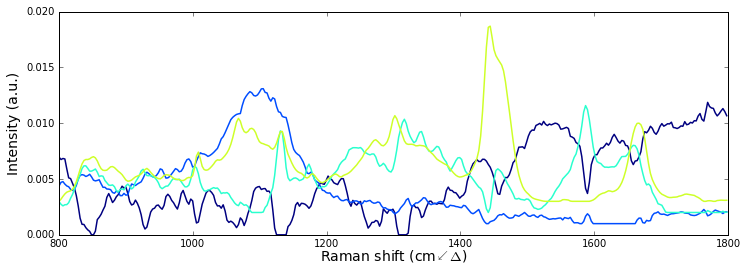

In [4]:
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 4)
for i in range(em_estim.shape[0]):
    axes.plot(a.wl, 0.001*i +  em_estim[i], linewidth=1.5, c=plt.cm.jet(float(i)/5.))
    
axes.set_ylabel("Intensity (a.u.)",fontsize=14);  
axes.set_xlabel("Raman shift (cm$^-1$)",fontsize=14, labelpad=-1)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


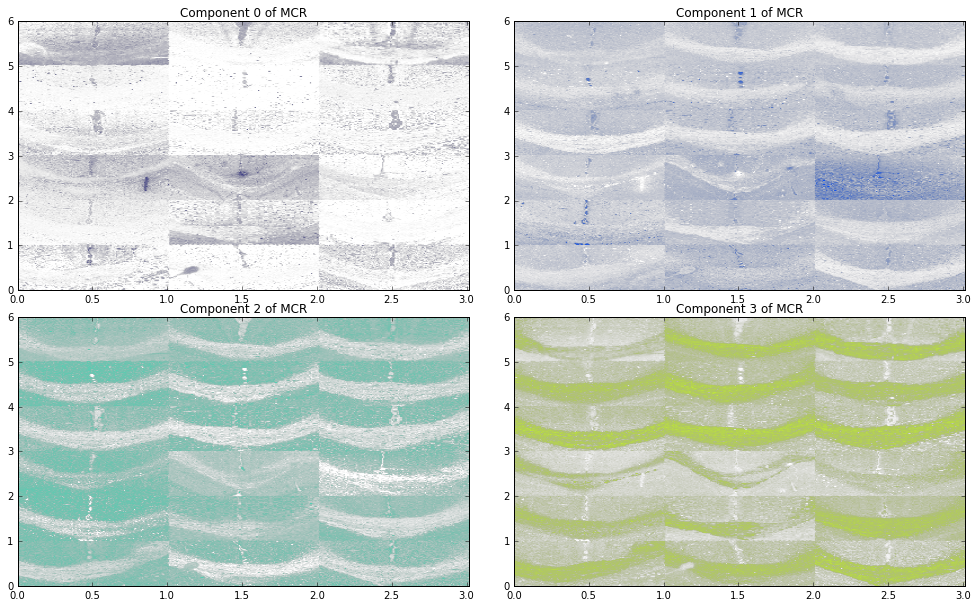

In [5]:
fig, axes = plt.subplots(2,2) ; fig.set_size_inches(14, 8)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
for i in range(4):
    Z, ext = create_grid_imshow(b.xy, ab_estim[:,i], resolution=800)
    im = axes[i/2,i%2].imshow(Z,extent=ext, aspect='auto', cmap=transparent_cmap(color=plt.cm.jet(float(i)/5.)))
    axes[i/2,i%2].set_title("Component "+str(i)+" of MCR")

### RMI estimation per image
Now that we have the pure components, we re-calculate the abundance maps for each image separately as well as we calculate their RMIs

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


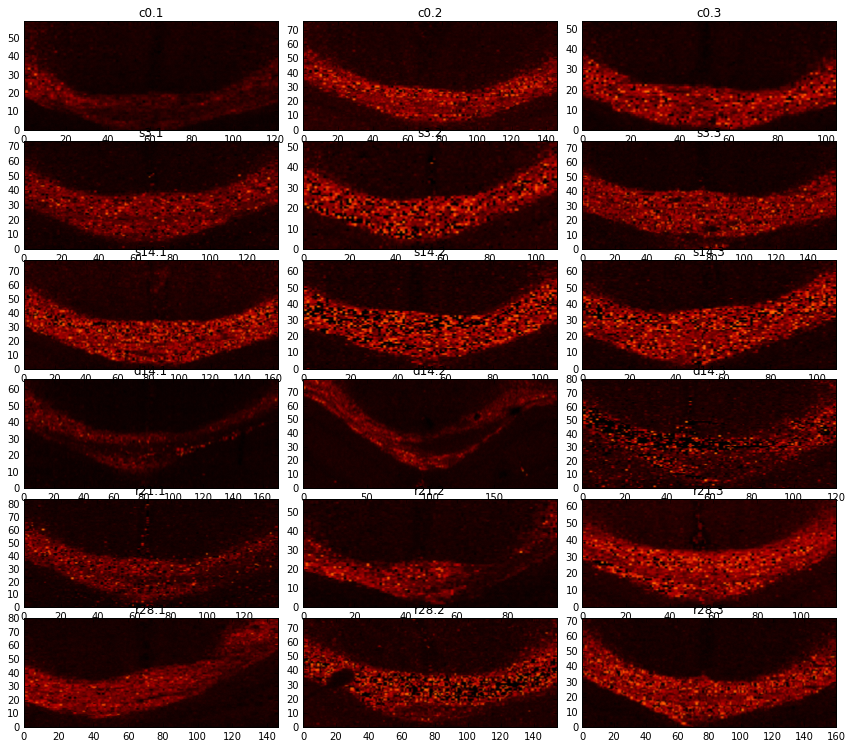

In [6]:
fig, axes = plt.subplots(6,3) ; fig.set_size_inches(12, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
RMI = list(range(len(pairfiles))) # initial list with dummy values
my_idx = 3; nm_idx = 2 #indexes of myelin and non-myelin, respectively

for f_idx in range(len(pairfiles)):
    # STEP 1 -- read each file into a specimage object
    rpy2.robjects.r['load'](path+"big/"+pairfiles[f_idx][0]+".Rdata")
    y=rpy2.robjects.numpy2ri.ri2py(rpy2.robjects.r['x'])
    a=SpecImage()
    a.wl = wl_axis # from file with wavelength numbers
    a.description = pairfiles[f_idx][0]
    n_y = y.shape[0]; n_x = y.shape[1]
    a.xy = np.array([[i,j] for i in range(n_x) for j in range(n_y)],dtype=float)
    a.spc = np.array([y[j,i] for i in range(n_x) for j in range(n_y)],dtype=float)
    a.idx = np.arange(n_y * n_x)
    # STEP 2 -- single-image preprocessing 
    a.set_wavelength_interval(800,1800)
    a.interpolate_spline(frac=1.)
    a.rescale_sum()
    # WL used for endmembers estimation may be diff from image, if we are reading previous run
    endmembers = np.array([np.interp(a.wl, em_wl, row) for row in em_estim],dtype=float)
    abund, endm, resid = a.find_abundance_maps(endmembers=endmembers)
    
    # STEP 3 -- reading mask files
    rpy2.robjects.r['load'](path+"big/"+pairfiles[f_idx][1]+"LEFT.Rdata")
    y=rpy2.robjects.numpy2ri.ri2py(rpy2.robjects.r['x'])
    n_y = y.shape[0]; n_x = y.shape[1]
    mask = np.array([y[j,i] for i in range(n_x) for j in range(n_y)],dtype=int) # boolean list (0 or 255)
    rpy2.robjects.r['load'](path+"big/"+pairfiles[f_idx][1]+"RIGHT.Rdata")
    y=rpy2.robjects.numpy2ri.ri2py(rpy2.robjects.r['x'])
    n_y = y.shape[0]; n_x = y.shape[1]
    mask += np.array([y[j,i] for i in range(n_x) for j in range(n_y)],dtype=int) # sum of left and right masks
    valid = [i for i, x in enumerate(mask) if x] # index of non-zero elements
    # another mask, of non-noise pixels
    non_noise, noise = a.remove_noisy_pixels(find_only=True)
    valid = sorted(set(non_noise) & set(valid)) # in hindsight, valid[] already have only non-noisy
    RMI[f_idx] = abund[valid,my_idx]/(abund[valid,nm_idx]+0.001)
    
    # STEP 4 -- plotting all pixels (notice that RMI is only for MASKED pixels)
    axs = axes[f_idx/3,f_idx%3]
    rmi =  abund[:,my_idx]/(abund[:,nm_idx]+0.001); ## for ALL pixels, not only masked
    rmi[ np.where(rmi>10)[0] ] = 0
    rmi[noise] = 0
    Z, ext = create_grid_imshow(a.xy, rmi, resolution=200)
    im = axs.imshow(Z,extent=ext, aspect='auto', cmap=plt.get_cmap("gist_heat"),vmin=0,vmax=14,interpolation='bicubic')
    axs.set_title(pairfiles[f_idx][0])

### Kernel density estimates of RMI, normalied to control
- pooled values over triplicates

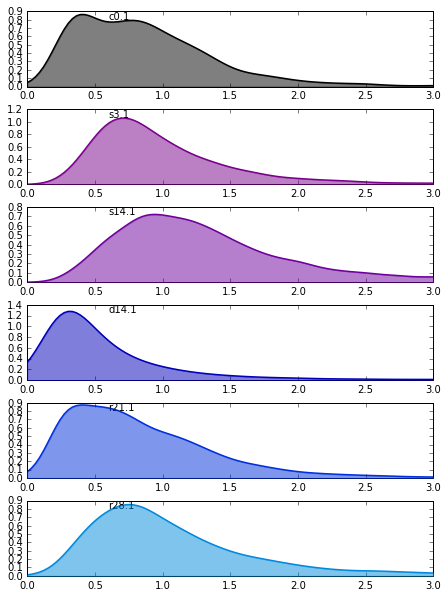

In [9]:
fig, axes = plt.subplots(6,1) ; fig.set_size_inches(6, 8)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.2, hspace=.3)
## normalization (over 3 replicates of control)
vals = np.append(RMI[0], RMI[1]); vals = np.append(vals, RMI[2]);
mean_control = vals.mean()

for i in range(6):
    vals = np.append(RMI[3*i], RMI[3*i+1]); vals = np.append(vals, RMI[3*i+2])/mean_control;
    density = gaussian_kde(vals)
    if i is 0:
        density.covariance_factor = lambda : .04 # set the covariance_factor, lower means more detail
    else:
        density.covariance_factor = lambda : .01 # set the covariance_factor, lower means more detail
    density._compute_covariance()
    #dx = np.linspace(0., np.percentile(vals,q=99),100)
    dx = np.linspace(0., 3., 100)
    dy = density(dx)
    axs = axes[i]
    axs.plot(dx, dy, linewidth=1.5, c=plt.cm.spectral(float(i)/18.))
    axs.fill_between(dx, dy, alpha=.5, zorder=5, antialiased=True, color=plt.cm.spectral(float(i)/18.))
    axs.text(0.2,0.9,pairfiles[3*i][0], fontsize=10, transform=axs.transAxes)
    axs.ticklabel_format(axis='x', style='sci', scilimits=(-3,3))